In [11]:
%matplotlib inline

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from qreservoirpy import QReservoir, Layers, utilities
from qiskit.providers.fake_provider import FakeManilaV2

from qiskit.circuit.library.standard_gates import HGate, SGate, CXGate, RC3XGate
backend = FakeManilaV2()


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier

models = np.array([
    SVC(kernel=ker) for ker in ['linear', 'poly', 'rbf', 'sigmoid']
] + [
    RidgeClassifier(alpha=alph) for alph in np.linspace(0, 1e-3, 20)
] + [
    KNeighborsClassifier(n_neighbors=n) for n in range(1, 10)
], dtype=object)

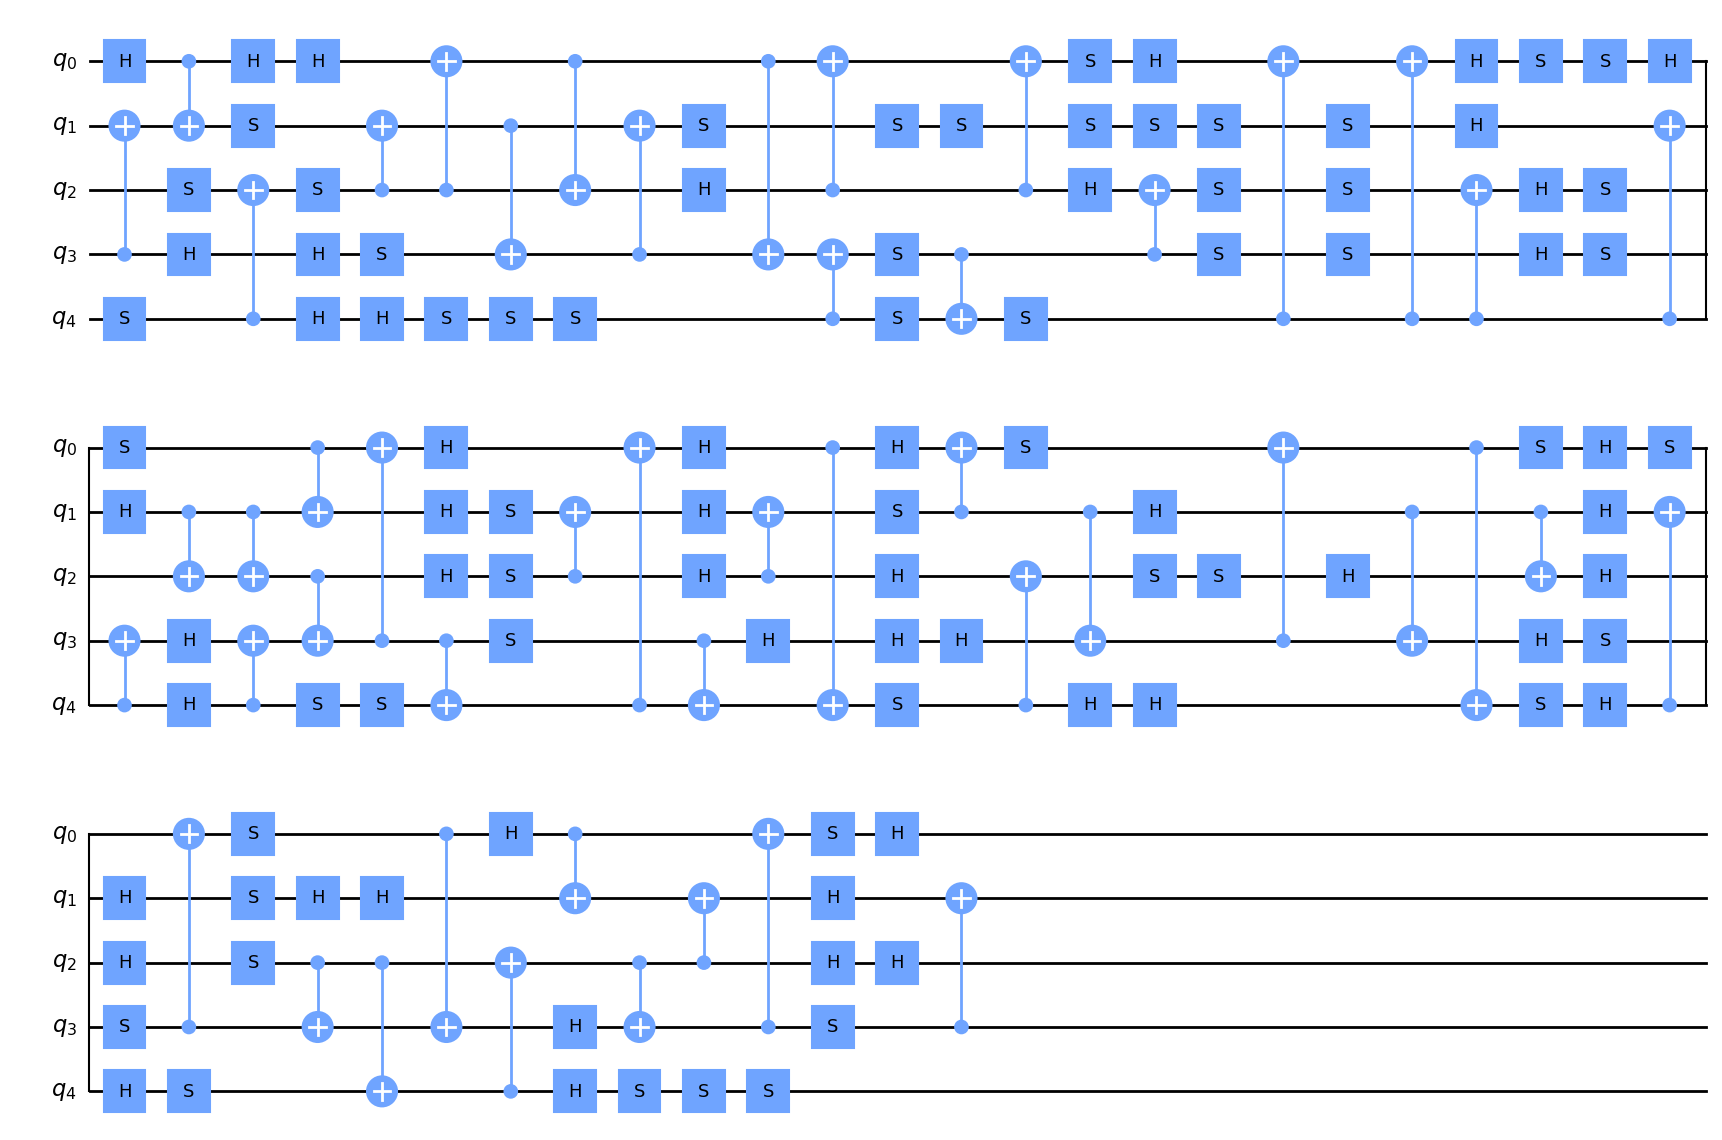

In [14]:
n_qubits = backend.num_qubits
shots = 10000
timeseries = [0, 1] * 30

circop = utilities.random_circuit(n_qubits, gates=[
    HGate, SGate, CXGate#, TGate
], depth=40)

op = circop.to_gate(label='RES')
circop.draw('mpl')


Simulating:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating: 100%|██████████| 1/1 [02:10<00:00, 130.70s/it]


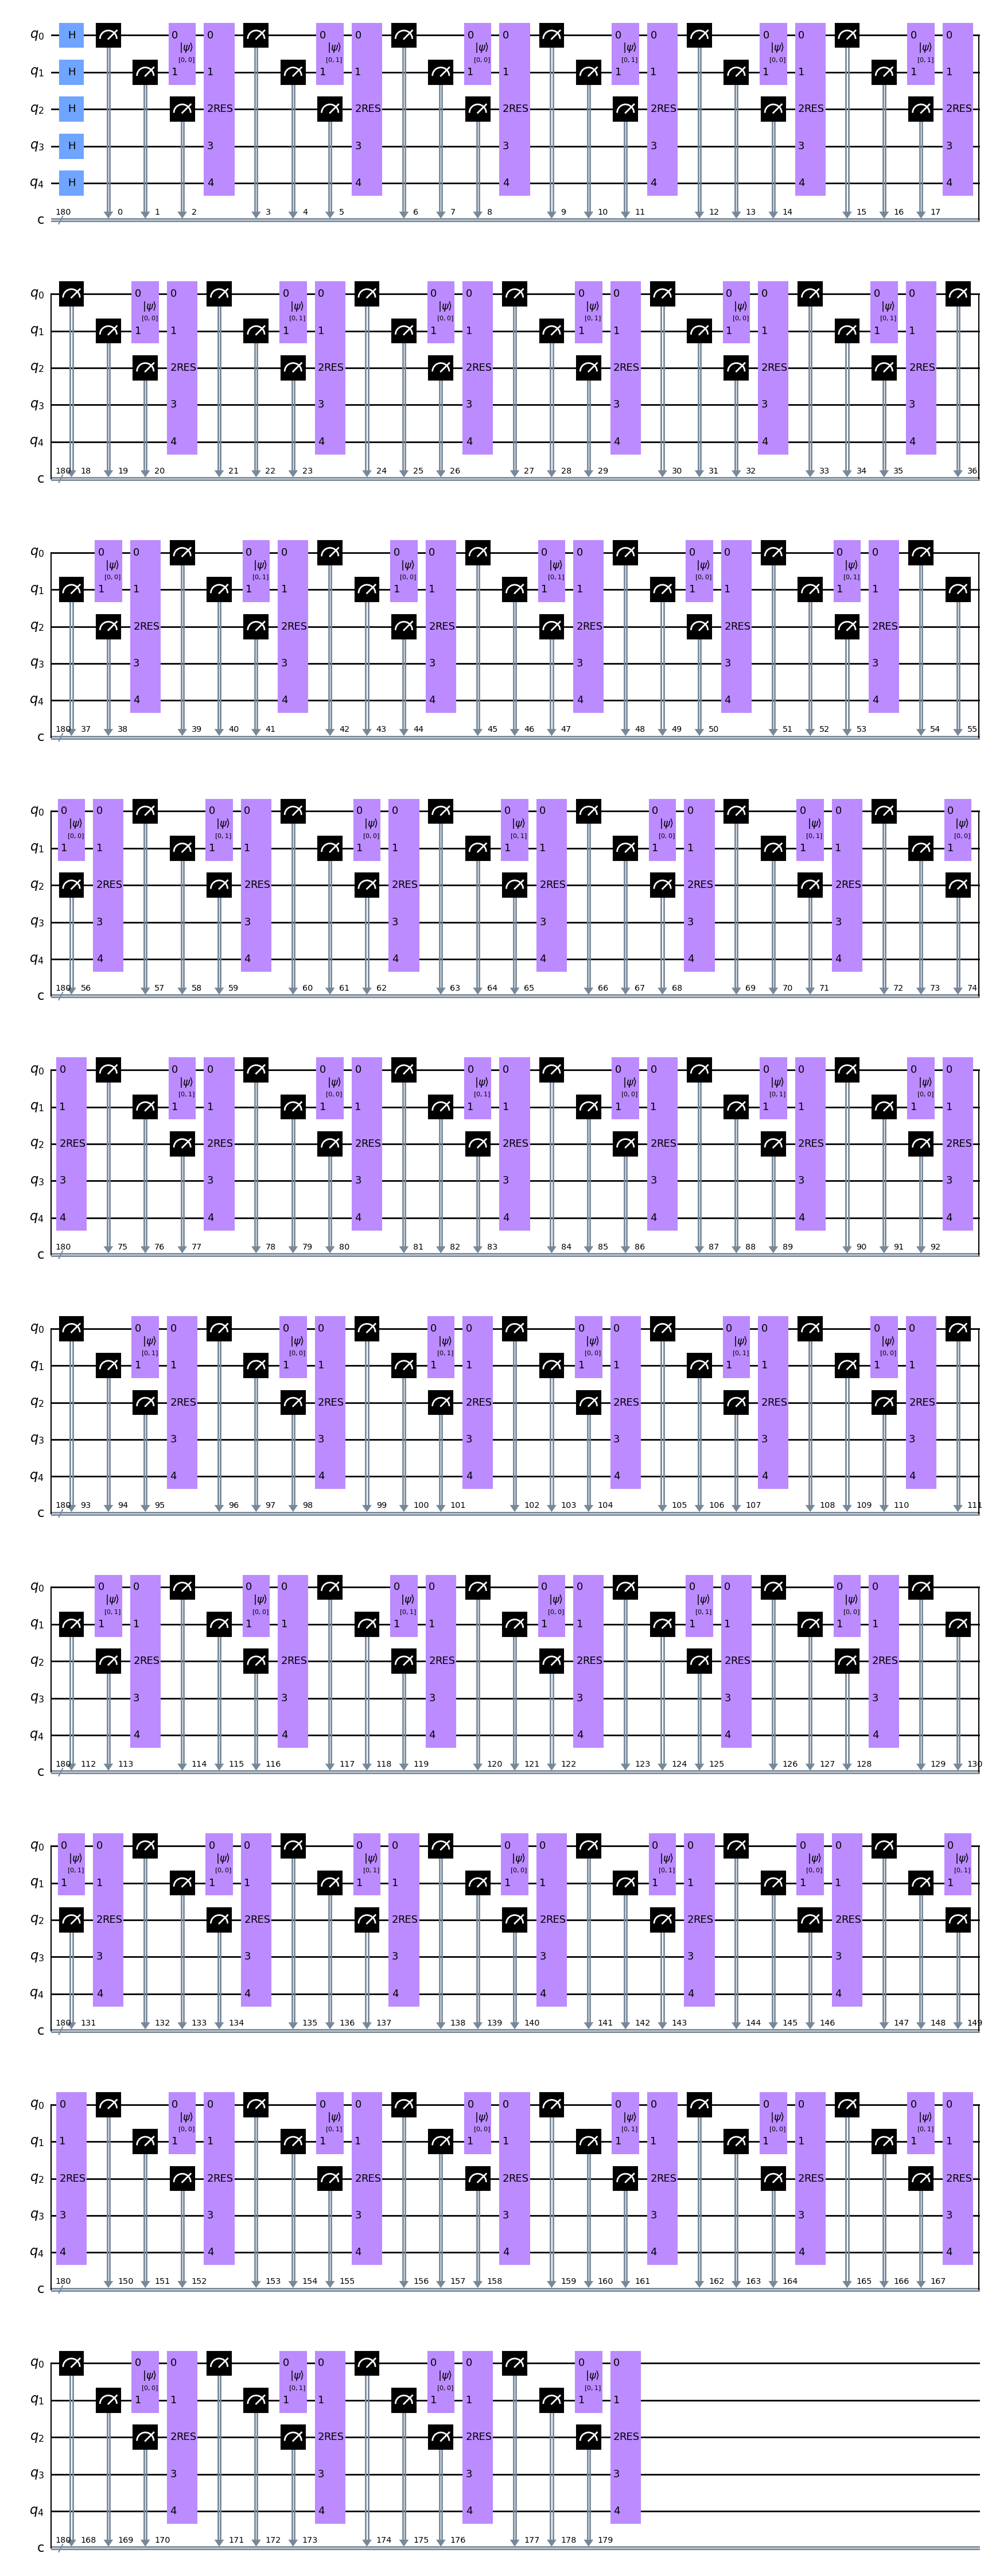

In [15]:
def build_method(circ, timestep, operator, encoder):
    circ.measure(range(3))
    circ.initialize(encoder[timestep], [0, 1])
    circ.append(operator,circ.qubits)
    return circ

res = QReservoir(
    qubits=n_qubits, 
    layers=[
        Layers.H(),
        Layers.Timeseries(build_method=build_method),
    ], 
    operator=op, 
    encoder={
        0: '00',
        1: '01',
        2: '10',
        3: '11'
    })


states = res.run(timeseries, shots=shots, transpile=True, backend=backend)
res.circuit.draw('mpl')


In [16]:
WARMUP = 0.1
warmup_idx = int(len(states) * WARMUP)
xstates = states[:-1][warmup_idx:]
target = timeseries[1:][warmup_idx:]



In [17]:

results = utilities.stress_test_models(xstates, target, models)
print(results)

[0.42111111 0.74       0.77833333 0.42111111 0.76055556 0.75833333
 0.75777778 0.75666667 0.75555556 0.75555556 0.75333333 0.75222222
 0.75055556 0.75       0.74888889 0.74833333 0.74777778 0.745
 0.74388889 0.74388889 0.74222222 0.74055556 0.73888889 0.73833333
 0.72777778 0.69111111 0.70888889 0.72       0.715      0.71611111
 0.73055556 0.74333333 0.74277778]


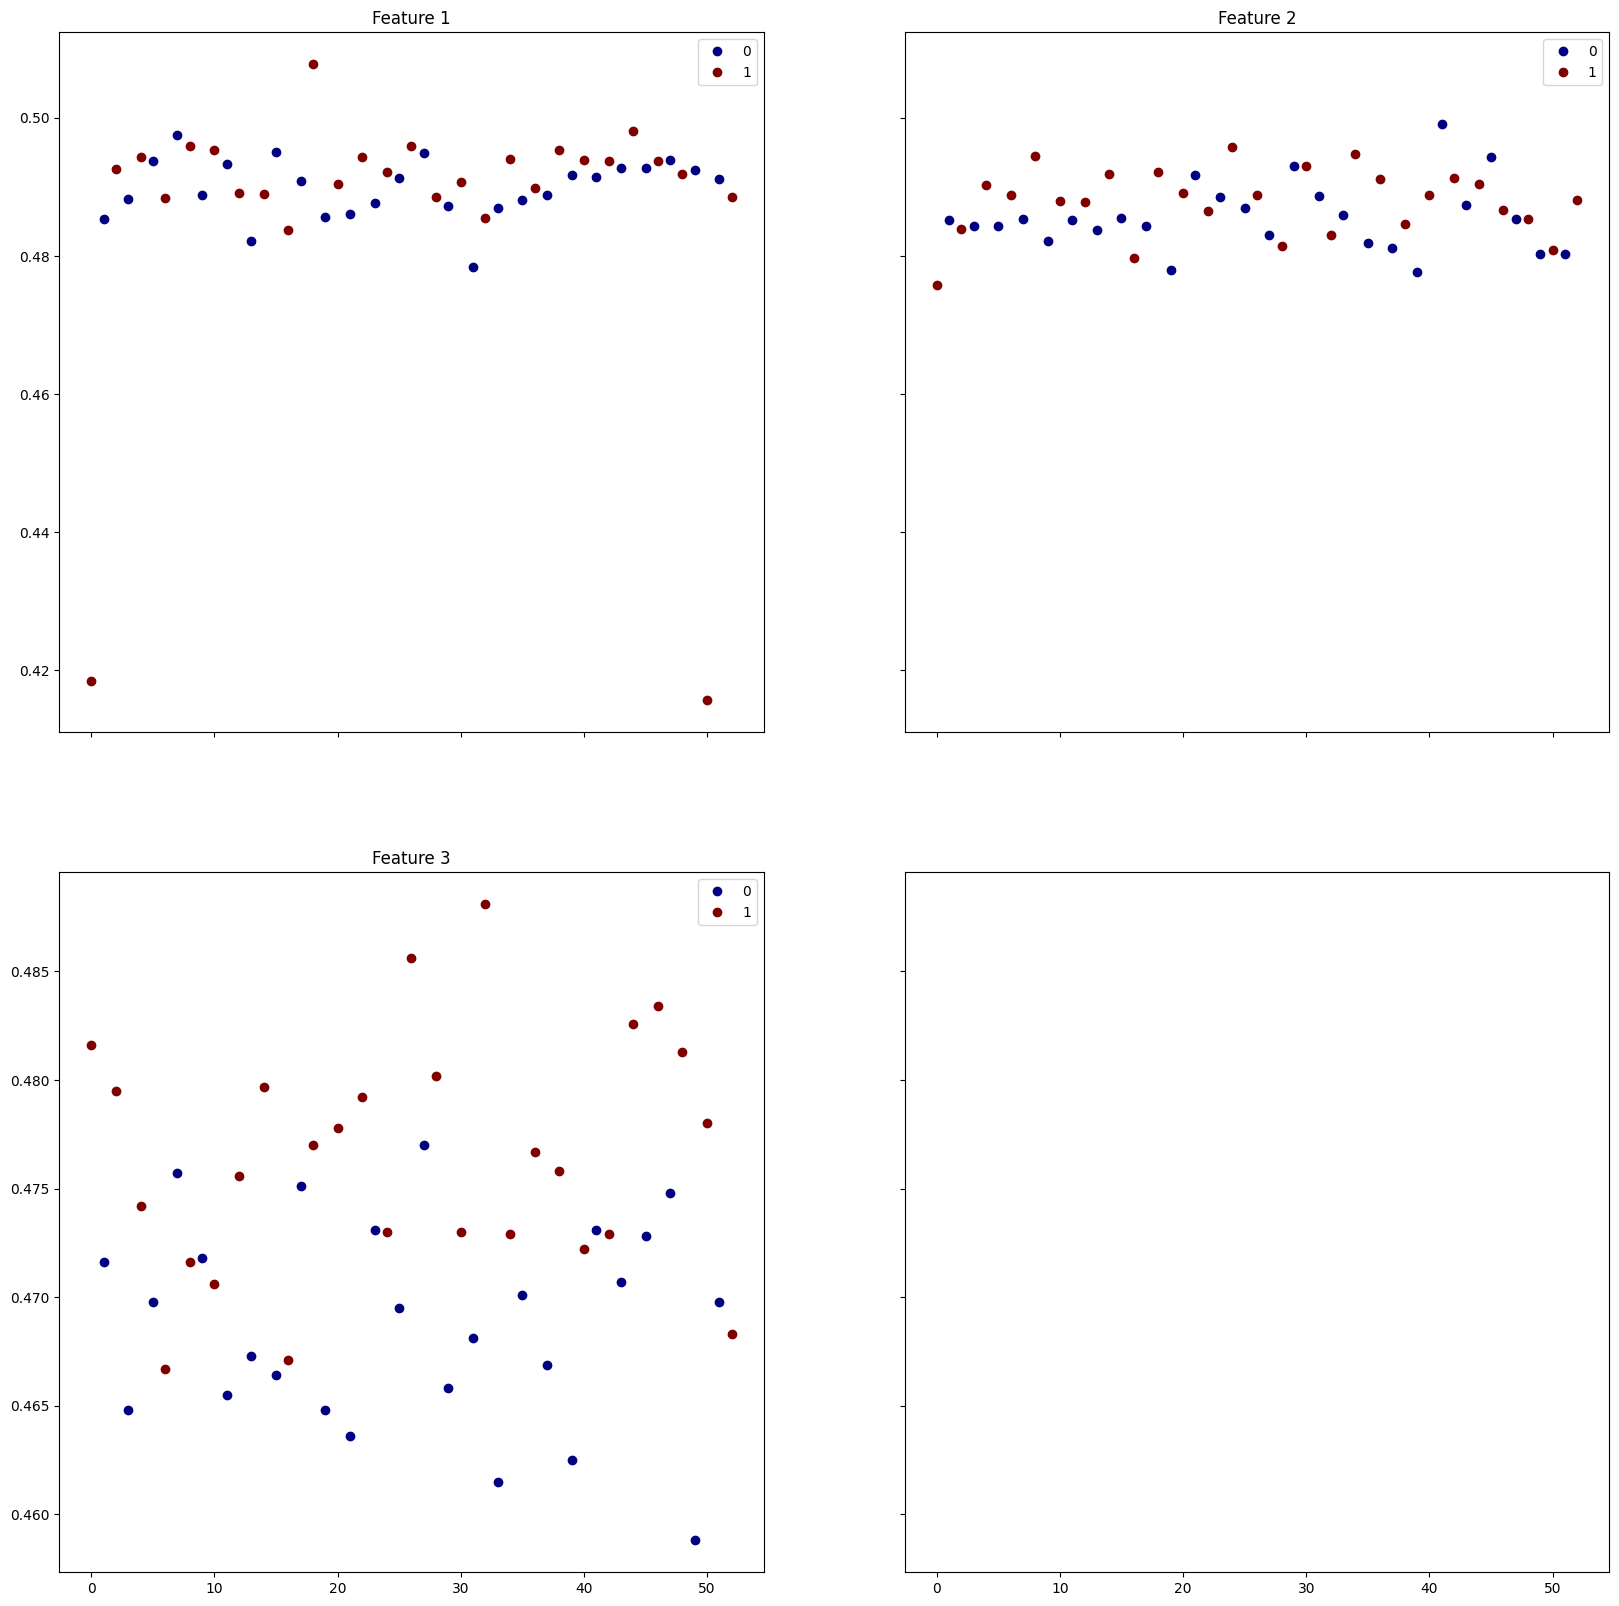

In [18]:
fig ,axes = utilities.result_plotter(xstates, target)



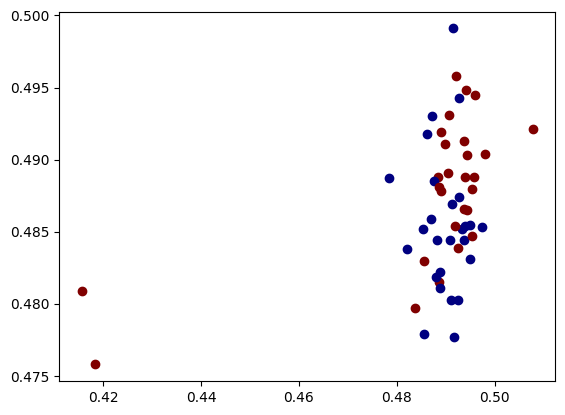

In [19]:
cmap = plt.get_cmap('jet', len(np.unique(target)))
for elem, x, y in zip(target, xstates[:, 0], xstates[:, 1]):
    plt.scatter(x, y, color=cmap(elem))

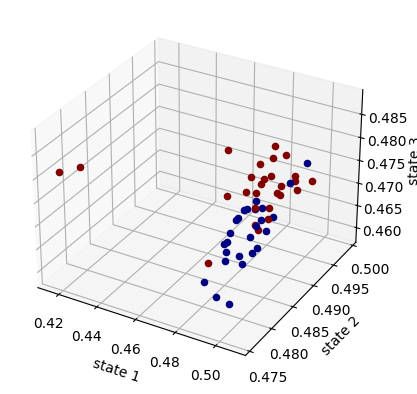

In [20]:
if xstates.shape[-1] >= 3:
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    cmap = plt.get_cmap('jet', len(np.unique(timeseries)))
    for i, x, y, z in zip(target, xstates[:, 0], xstates[:, 1], xstates[:, 2]):
        ax.scatter(x, y, z, color=cmap(i))
    ax.set_xlabel('state 1')
    ax.set_ylabel('state 2')
    ax.set_zlabel('state 3')
    